# Homework 5
## Flat Fields and Standard Star Corrections

In [15]:
#Import all of the packages that I will need for this project.
from astropy.io import fits
import numpy as np
from astropy.stats import mad_std #Standard deviation from median absolute deviation.
import sys
import os
import glob
import progressBar as pb
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['figure.figsize']=(15.0,12.0)
matplotlib.rc('font',size=20)

In [2]:
#A simple function to open images in ds9.
def show_img(show_file):
    cmd = 'ds9 {} &'.format(show_file)
    os.system(cmd)

In [3]:
#This is for sigma clipping a 1-D set of data.
def sigclip(in_arr,upper=3.0,lower=3.0,avg_func=np.median,std_func=mad_std,return_margins=False,weighted=False,tweights=np.array([1,1,1,1,1,1,1])):
    temp_data = np.ravel(in_arr)
    if weighted==True:
        temp_weights = tweights
    wgood = np.where((np.isnan(temp_data)==False)&(np.isinf(temp_data)==False))[0]
    temp_data = temp_data[wgood]
    if weighted==True:
        temp_weights = temp_weights[wgood]
    sdelt = 1
    
    while sdelt:
        temp_dev = std_func(temp_data)
        if weighted == False:
            temp_avg = avg_func(temp_data)
        if weighted == True:
            temp_avg = np.average(temp_data,weights=temp_weights)
        ognum_vals = len(temp_data)
        lower_margin = temp_avg - (lower * temp_dev)
        upper_margin = temp_avg + (upper * temp_dev)
        wkeep = np.where((temp_data > lower_margin)&(temp_data<upper_margin))[0]
        temp_data = temp_data[wkeep]
        if weighted==True:
            temp_weights = temp_weights[wkeep]
        sdelt = ognum_vals - len(temp_data)
    
    if return_margins == True:
        return temp_data, lower_margin, upper_margin
    else:
        return temp_data

In [4]:
#This is a utility function with the job of finding the statistical information of an array.
#Mainly useful for flats, darks, and biases. Not as useful for a science frame.
def desc_array(arr_in,out_table=False):
    desc_arr = np.zeros(1,dtype=[('MIN_ADU','f4'),('MAX_ADU','f4'),('RANGE_ADU','f4'),
                                ('MEAN_ADU','f4'),('STD_ADU','f4'),('MED_ADU','f4'),('RMS','f4')])
    desc_arr['MIN_ADU'] = np.amin(arr_in)
    desc_arr['MAX_ADU'] = np.amax(arr_in)
    desc_arr['RANGE_ADU'] = np.amax(arr_in) - np.amin(arr_in)
    desc_arr['MEAN_ADU'] = np.mean(arr_in)
    desc_arr['STD_ADU'] = np.std(arr_in)
    desc_arr['MED_ADU'] = np.median(arr_in)
    desc_arr['RMS'] = np.sqrt(np.mean(np.square(arr_in)))
    if out_table == True:    
        for i in range(7):
            name_temp = desc_arr.dtype.names[i]
            print('{0:9} | {1:7.3f} adu'.format(name_temp,desc_arr[name_temp][0]))
    return desc_arr

In [5]:
#This program was set to combine the flat files into a single array I could perform combinations
#on. I decided not to use it in the end and went with the IRAF functions instead, seen below.
def mk_flat_arr(color_in):
    #Load the flats_list file
    flat_list = np.loadtxt('flat_list.dat',delimiter=',',dtype=bytes).astype(str)
    #Look at the specified color of flats
    wC = np.where(flat_list[:,1] == color_in)[0]
    file_numC = flat_list[:,0][wC]
    file_namesC = np.chararray(len(wC),itemsize=11,unicode=True)
    num_files = len(wC)
    for i in range(num_files):
        file_namesC[i] = 'a0{}_z.fits'.format(file_numC[i])
    
    comb_flatarr = np.zeros((2048,2048,num_files),dtype='f4')
    for i in range(num_files):
        temp_flat = fits.open(file_namesC[i])[0].data
        comb_flatarr[:,:,i] = temp_flat[:,:]
    
    return num_files, file_namesC, comb_flatarr

### 1) Combining V-band Flats for comparison

I used five methods to combine the flats below (using IRAF). I then looked at the stats for each of the methods to find the "best" way to combine flats. Although I believe the fifth way (combine=median, weight=mean, reject=sigclip) to be the best, over the full image it has the same RMS as the straight median combine. There are artifacts that remain in the master flats (the "eyelash" seen in the top left quadrant), but these also appear in science images as well. This should mean that whatever master flat I use, these artifacts will be removed from the science images when I divide by the normalized flat.

In addition, all master flats use the "scale=mean" option so they are all scaled, in raw counts, to the first image in the attendant "flats.list" file (this removes the exposure time as a variable).

Using iraf to make the flat files:
- epar imcombine
- 0) set SCALE to mean
- 1) set the weight to none, combine to average, reject to none
- 2) set the weight to none, combine to median, reject to none
- 3) set the weight to none, combine to average, reject to sigclip
- 4) set the weight to mean, combine to average, reject to sigclip
- 5) set the weight to mean, combine to median, reject to sigclip
- Then run imcombine for each of the five option sets above with the following command:
- imcombine @vflats.list (and name each output file as I go)
- Get files: masterflat_avg_v (1), masterflat_med_v (2), masterflat_sig_v (3), masterflat_asw_v (4), masterflat_msw_v (5),
- Look at statistics of each flat:
- imexam @masterflats.list
- OR use my desc_array above

In [142]:
masterflats_list = glob.glob('masterflat*_v.fits')
num_masters = len(masterflats_list)
mstr_arr = np.zeros(1,dtype=[('MIN_ADU','f4'),('MAX_ADU','f4'),('RANGE_ADU','f4'),
                                ('MEAN_ADU','f4'),('STD_ADU','f4'),('MED_ADU','f4'),('RMS','f4')])
for i in range(num_masters):
    temp_flat = fits.open(masterflats_list[i])[0].data
    temp_desc = desc_array(temp_flat,out_table=False)
    if i == 0:
        print('  NAME    |  MEAN ADU  |  STD ADU  |    RMS     | MIN ADU |  MAX ADU    | MEDIAN ADU ')
        print('------------------------------------------------------------------------------------')
    print('{:9} | {:9,.3f}  | {:8,.4f}  | {:9,.3f}  | {:6,.3f}  | {:9,.3f}  | {:9,.3f} '.format(masterflats_list[i][11:-5],
                                                                           temp_desc['MEAN_ADU'][0],
                                                                           temp_desc['STD_ADU'][0],
                                                                           temp_desc['RMS'][0],temp_desc['MIN_ADU'][0],
                                                                           temp_desc['MAX_ADU'][0],
                                                                           temp_desc['MED_ADU'][0]))
    

  NAME    |  MEAN ADU  |  STD ADU  |    RMS     | MIN ADU |  MAX ADU    | MEDIAN ADU 
------------------------------------------------------------------------------------
avg_v     | 9,185.422  | 142.5927  | 9,186.527  |  4.570  | 21,507.662  | 9,197.136 
med_v     | 9,184.377  | 133.8263  | 9,185.346  |  4.967  | 17,266.309  | 9,197.000 
sig_v     | 9,185.422  | 142.5927  | 9,186.527  |  4.570  | 21,507.660  | 9,197.136 
asw_v     | 9,185.795  | 138.5879  | 9,186.842  |  4.769  | 18,372.225  | 9,197.706 
msw_v     | 9,184.377  | 133.8263  | 9,185.346  |  4.967  | 17,266.309  | 9,197.000 


Here we can see each image was scaled to the flat with the lowest mean value, but the weighted median sigma-clipped combination has the lowest RMS value.

### 2) Making Color flats:
I set the parameters in the imcombine file (combine=median,reject=sigclip,scale=mean,weight=mean) and created a flat for each color. The flats are:
- masterflat_ha.fits
- masterflat_u.fits
- masterflat_b.fits
- masterflat_v.fits
- masterflat_r.fits
- masterflat_i.fits

### 3) Normalizing Master Flats

I performed this below with python rather than IRAF. As I was dividing the full masterflat by a single value, it was quicker to write a short python script that did this.

In [143]:
#Normalize the master flats against their mean so I don't lose photon statistics.
master_list = glob.glob('masterflat_*fits')
num_masters = len(master_list)
for i in range(num_masters):
    temp_master = fits.open(master_list[i])[0].data
    temp_mean = np.mean(temp_master)
    temp_arr = np.zeros((2048,2048),dtype='f4')
    temp_arr[:,:] = temp_master / temp_mean
    temp_hdu = fits.PrimaryHDU(temp_arr)
    temp_name = master_list[i]
    outname = temp_name.replace('.fits','_norm.fits')
    temp_hdu.writeto(outname)

### 4) Flattening Science Images

Used iraf to remove the flat for each color from all science images:
- imarith @hasci.list / masterflat_ha_norm.fits @hasci_out.list
- imarith @usci.list / masterflat_u_norm.fits @usci_out.list
- imarith @bsci.list / masterflat_b_norm.fits @bsci_out.list
- imarith @vsci.list / masterflat_v_norm.fits @vsci_out.list
- imarith @rsci.list / masterflat_r_norm.fits @rsci_out.list
- imarith @isci.list / masterflat_i_norm.fits @isci_out.list

I also used iraf to remove the masterflat from each flat (output as _zbf)
Midpoint note: _z - Overscan removed, _zb - Masterbias removed, _zbf - Norm Masterflat removed

### 5) Finding the Gain

GAIN: 1.82438 e- / ADU


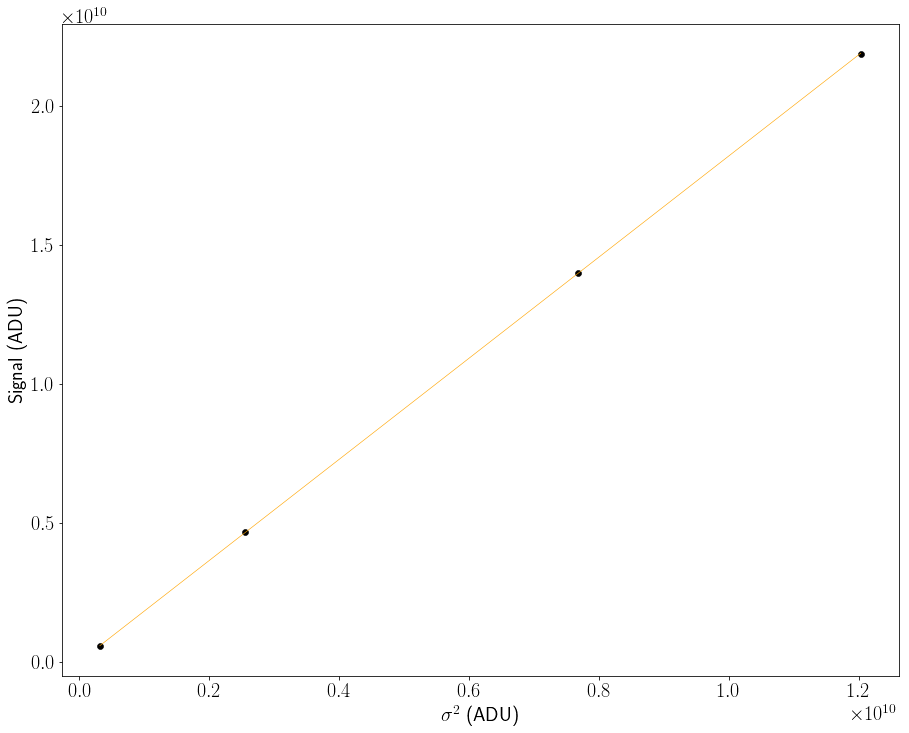

In [16]:
#REGION0 [936:1045,999:1097], NPIX = 10807, MEAN=52073, STD = 170.6
#REGION1 [828:1152,910:1187], NPIX = 89659, MEAN=52068, STD = 168.7
#REGION2 [692:1266,811:1281], NPIX = 268758, MEAN=52065, STD = 169.0
#REGION3 [631:1337,753:1351], NPIX = 420269, MEAN=52062, STD = 169.2
npix = np.array([10807,89659,268758,420269])
means = np.array([52073,52068,52065,52062])
std = np.array([170.6,168.7,169.0,169.2])
signal = npix*means
noise = npix*std**2
snprm = np.polyfit(noise,signal,1)
sn_xfit = np.linspace(np.amin(noise),np.amax(noise),1000)
sn_yfit = np.polyval(snprm,sn_xfit)
plt.scatter(noise,signal,linewidth=0.6,color='black')
plt.plot(sn_xfit,sn_yfit,linewidth=0.6,color='orange')
plt.xlabel(r'$\sigma^{2}$ (ADU)')
plt.ylabel('Signal (ADU)')
slope = (signal[2]-signal[0])/(noise[2]-noise[0])
print('GAIN: {:1.5f} e- / ADU'.format(slope))


Above I selected four regions (by drawing concentric boxes in ds9) in a flat, ensuring stars were not selected. I used IRAF's imstat on these regions to find the mean counts, number of pixels, and standard deviation of these regions. Plotting them above you can see that the function is linear, so the slope was computed, which was the gain. The gain I computer as ~1.84, but the reported gain of the WIRO Prime instrument was 2.5 (e-/ADU). I used this 2.5 value later when I performed photometry on the standard stars.

### 6) FWHM of PG1633+099B
Below I looked at star 'B' at different times throughout the night in the V-band. This takes different air masses into account to see how they affect the PSF width of my star (it doesn't really). No matter the "apparent" size in the image they are all roughly 3 pixels large (this is ~99% of the star's flux).
Looking at PG1633+099B
- using a085_zbf: FLUX=1054000 SKY=141.9 X=1.18
- using a134_zbf: FLUX=522078 SKY=66.09 X=1.24
- using a206_zbf: FLUX=500861 SKY=72.17 X=1.52

### 7) Centroid Accuracy

Here I looked at different stars in the same image with the same airmass. 'A' is the dim star, 'D' is the mid-brightness star, and 'B' is the brightest star (almost saturated a the center).

A plot appears below, but it appears that centroid accuracy doesn't change with star brightness within this range.

The balues below were found with IRAF's imexam function making x and y cuts on a star. FWHM(r), FLUX, and SKY were found with radial profiles.

Looking at a085_zbf:
- PG1633+099B
  - Center: 1252.7$\pm$1.598, 1222.43$\pm$1.696,
  - FWHM(x): 3.708, FWHM(y): 3.977
  - FLUX: 1054000., SKY: 141.9, FWHM(r): 3.51

- PG1633+099A:
  - Center: 1191.44$\pm$1.587, 1044.23$\pm$1.715
  - FWHM(x): 3.692, FWHM(y): 4.038
  - FLUX: 129693., SKY: 123.6, FWHM(r): 3.49

- PG1633+099D:
  - Center: 1445.01$\pm$1.618, 1183.04$\pm$1.695
  - FWHM(x): 3.811, FWHM(y): 3.991
  - FLUX: 564134, SKY: 132.6, FWHM(r): 3.54
  
Plotting standard deviation of centroid accuracy $\sigma_{xy} = \sqrt{\sigma_{x}^{2} + \sigma_{y}^{2}}$ below:

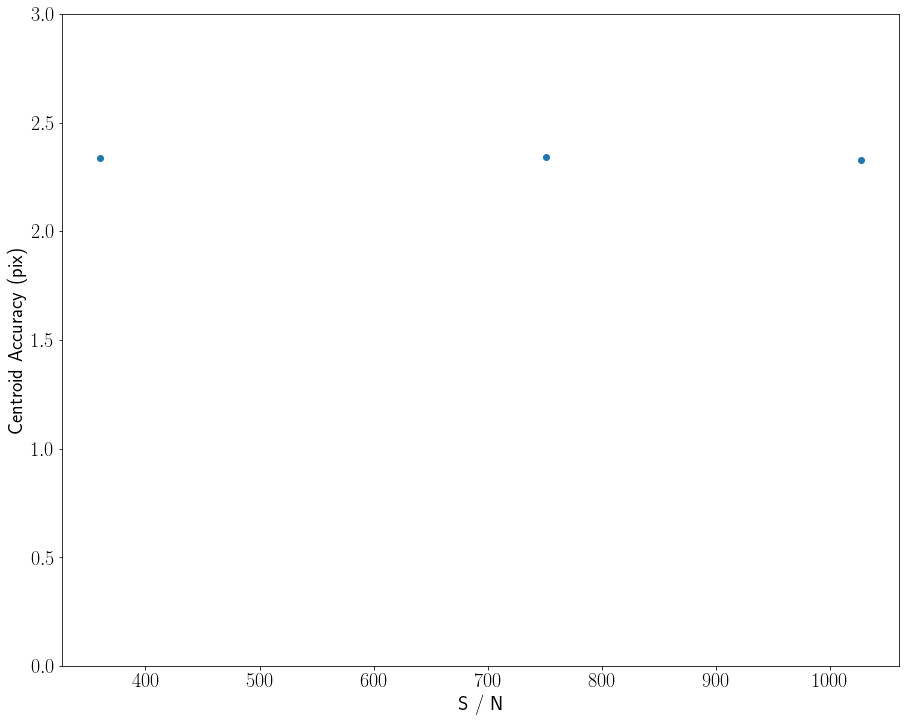

In [17]:
sigmax = np.array([1.587,1.618,1.598]) #A,B,D
sigmay = np.array([1.715,1.695,1.696])
sigmaT = np.sqrt(sigmax**(2) + sigmay**(2))
signal = np.array([129693,564134,1054000])
noise = np.sqrt(signal)
signoise = signal / noise
plt.scatter(signoise,sigmaT)
plt.ylim((0,3))
plt.xlabel('S / N')
plt.ylabel('Centroid Accuracy (pix)');

This looks more like scatter around a horizontal line rather than a polynomial relationship. It appears that centroid accuracy is roughly constant with S/N.

### 8) Using PHOT in IRAF

I chose four stars in the PG1633+099 field, A,B,D, and I. In the tables in Landolt et al. (1992), 'I' is the star listed as PG1633+099 without a letter. I selected the V-band image of this field at the lowest airmass to look at the photometry work. Below are the parameters I ran for 5 aperture sizes (with 5 sky annulus sizes) to find the flux of these different stars. Stars were selected with coordinate files made by drawing circular regions in ds9 to find the star centers.

- image a085_zbf.fits (V-band standard field)
- Aperture sizes: 1,3,5,10,20
- dannulus sizes: 5
- annulus sizes: 5,10,15,20,30
- Stars in PG1633+099
- Dim - A, Medium - I, Bright - D, Super bright - B


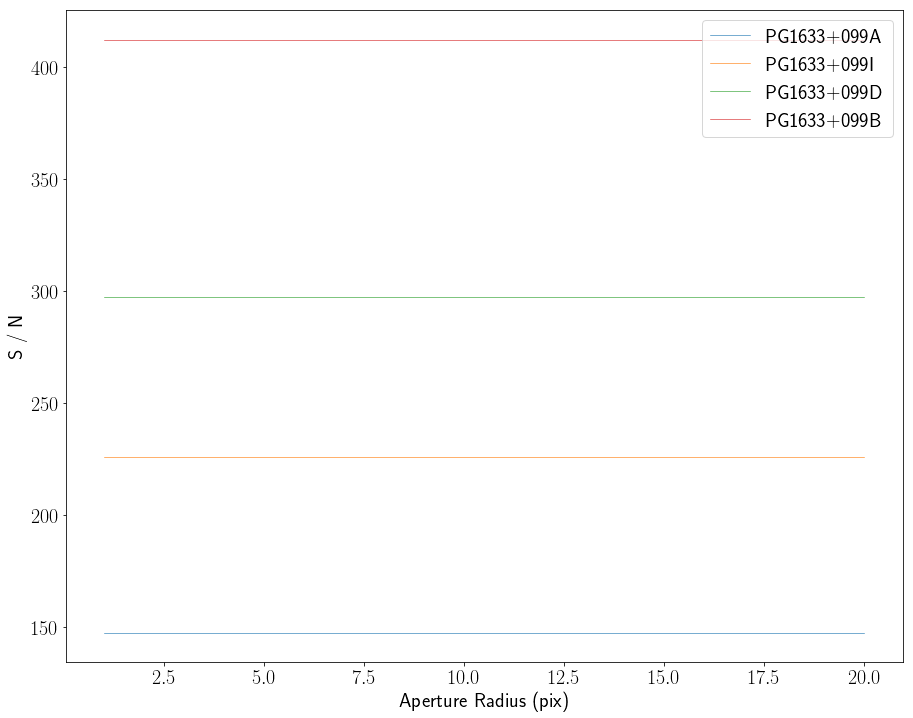

In [18]:
phot_arr = np.zeros(20,dtype=[('ID','i2'),('OBJ_CHAR','U1'),('APER','i2'),('ANNU','i2'),
                             ('EXPTIME','i2'),('AIRMASS','f4'),('MEAN_SKY','f4'),('FLUX','f4')])
for i in range(5):
    lower = i*4
    upper = lower + 4
    temp_name = '../sci/v/old_phot/phot_a085_{}clean.dat'.format(i)
    arr_temp = np.loadtxt('../sci/v/old_phot/phot_a085_0clean.dat',dtype=bytes).astype(str)
    #print(arr_temp)
    phot_arr['OBJ_CHAR'][lower:upper] = np.array(['A','I','D','B'])
    if i == 0:
        phot_arr['APER'][lower:upper] = 1
        phot_arr['ANNU'][lower:upper] = 5
    elif i == 1:
        phot_arr['APER'][lower:upper] = 3
        phot_arr['ANNU'][lower:upper] = 10
    elif i == 2:
        phot_arr['APER'][lower:upper] = 5
        phot_arr['ANNU'][lower:upper] = 15
    elif i == 3:
        phot_arr['APER'][lower:upper] = 10
        phot_arr['ANNU'][lower:upper] = 20
    elif i == 4:
        phot_arr['APER'][lower:upper] = 20
        phot_arr['ANNU'][lower:upper] = 30
    for j in range(4):
        idex = lower + j
        phot_arr['ID'][idex] = int(arr_temp[j,0])
        phot_arr['EXPTIME'][idex] = int(float(arr_temp[j,1]))
        phot_arr['AIRMASS'][idex] = float(arr_temp[j,2])
        phot_arr['MEAN_SKY'][idex] = float(arr_temp[j,3])
        phot_arr['FLUX'][idex] = float(arr_temp[j,4])
    #print(arr_temp[0,4])
#print(phot_arr)
lab_arr = np.array(['A','I','D','B'])
for k in range(4):
    wlab = np.where(phot_arr['OBJ_CHAR']==lab_arr[k])[0]
    sN = np.sqrt(phot_arr['FLUX'][wlab])
    aPP = phot_arr['APER'][wlab]
    lab_str = 'PG1633+099{}'.format(lab_arr[k])
    plt.plot(aPP,sN,linewidth=0.6,label=lab_str)
plt.xlabel('Aperture Radius (pix)')
plt.ylabel('S / N')
plt.legend();

It would appear that aperture size has no major difference on Signal-to-Noise ratio. By inspection, however, all of the stars used have a PSF width of ~3 pixels. So I'll use an aperture of 3, and a sky annulus of 20.

### 9) Instrumental Magnitudes through PHOT

Below are the parameters for each image (and which images) I used to find the magnitudes are the four standard stars listed above (A,I,D,B). The times and airmasses were found in the log file.

The following are the images I will use for each airmass and each of the three color filters we are using.

- V - a085 X = 1.18, ITIME = 20
- B - a083 X = 1.18, ITIME = 30
- R - a087 X = 1.18, ITIME = 10

- V - a134 X = 1.24, ITIME = 10
- B - a132 X = 1.24, ITIME = 30
- R - a136 X = 1.24, ITIME = 10

- V - a206 X = 1.52, ITIME = 10
- B - a204 X = 1.51, ITIME = 30
- R - a208 X = 1.53, ITIME = 10

- V - a241 X = 2.21, ITIME = 10
- B - a239 X = 2.19, ITIME = 30
- R - a243 X = 2.23, ITIME = 10

  - Command to do photometry:
  - Using aperture of 3 pixels, annulus of 20 pixels, dannulus of 5 pixels, readnoi=4.5, epadu=2.5
  - phot input_file.fits coords='coord_file' output='output_file.dat' datapars.itime=exp_time datapars.xairma=airmass interact- verify-
  - TEXT DUMP COMMAND:
  - txdump phot_file.dat LID,ITIME,XAIRMASS,MSKY,FLUX,MAG,MERR,SUM expr="yes" > phot_clean.dat

### 11) Extinction Coefficients and Zero Point

Directly below is the format of the PHOT txtdump files so I know what column leads to which measurement. V-band information was done first as a test bed to make sure the python scripts worked to load the various phot files and fit the line.

I chose to correct for the airmass extinction and for the instrumental->calibrated magnitude in the first step. Following these corrections I did the color corrections for the various stars. A table of all of these corrective coefficients can be found at the end of the document.

phot_a085_clean.dat Format:
LID, Exposure Time, Airmass, Mean Sky, Flux, Magnitude,Mag_err, Total Counts

Extinction Coefficient (kv): -0.448
Zero Point Offset (zpV): 0.045


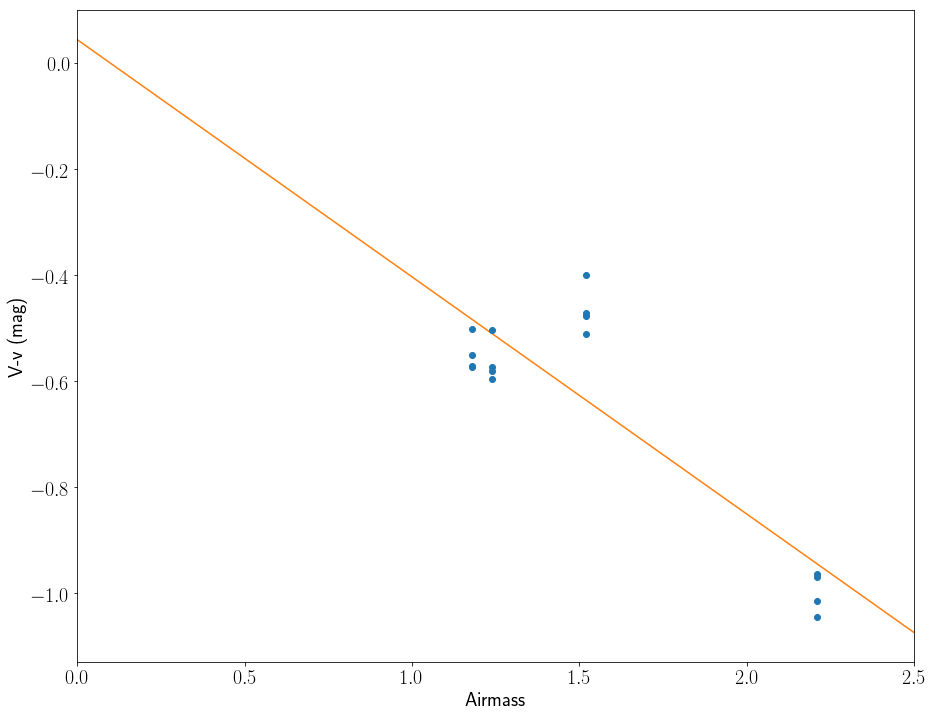

In [20]:
#This is the script for working with the V-band data.
vband_arr = np.zeros(16,dtype=[('ID','f4'),('EXPTIME','f4'),('AIRMASS','f4'),('MEAN_SKY','f4'),
                              ('FLUX','f4'),('MAG','f4'),('MAG_ERR','f4'),('SUM_CNTS','f4')])
vfiles = glob.glob('../sci/v/phot*clean.dat')
vfiles = np.sort(vfiles)
colnames = vband_arr.dtype.names
num_cols = len(colnames)
for i in range(len(vfiles)):
    lower = i * 4
    upper = lower + 4
    temp_arr = np.loadtxt(vfiles[i],dtype='f4')
    for j in range(num_cols):
        vband_arr[colnames[j]][lower:upper] = temp_arr[:,j]
#print(vband_arr)
i99 = 14.396 #PG 1633+099I v-band magnitude
a99 = 15.256
b99 = 12.969
d99 = 13.691
mag_diff = np.zeros(16,dtype=[('OBJ_CHAR','U1'),('AC_MAG','f4'),('INS_MAG','f4'),('CORR_MAG','f4'),
                              ('MAG_DIFF','f4'),('AIRMASS','f4'),('MAG_ERR','f4')])
for i in range(16):
    mag_diff['INS_MAG'][i] = vband_arr['MAG'][i]
    if vband_arr['ID'][i] == 1.:
        mag_diff['OBJ_CHAR'][i] = 'A'
        mag_diff['AC_MAG'][i] = a99
    elif vband_arr['ID'][i] == 2.:
        mag_diff['OBJ_CHAR'][i] = 'I'
        mag_diff['AC_MAG'][i] = i99
    elif vband_arr['ID'][i] == 3.:
        mag_diff['OBJ_CHAR'][i] = 'D'
        mag_diff['AC_MAG'][i] = d99
    elif vband_arr['ID'][i] == 4.:
        mag_diff['OBJ_CHAR'][i] = 'B'
        mag_diff['AC_MAG'][i] = b99
    mag_diff['AIRMASS'][i] = vband_arr['AIRMASS'][i]
    mag_diff['MAG_ERR'][i] = vband_arr['MAG_ERR'][i]
    mag_diff['MAG_DIFF'][i] = mag_diff['AC_MAG'][i] - mag_diff['INS_MAG'][i]
        
#1: A, 2: I, 3: D, 4: B
#maxmag = np.amax(vband_arr['MAG']+3)
prm = np.polyfit(mag_diff['AIRMASS'],mag_diff['MAG_DIFF'],1)
kv1 = prm[0] #EXTINCTION COEFFICIENT FOR V-band
zpv = prm[1]
print('Extinction Coefficient (kv): {:05.3f}'.format(kv1))
print('Zero Point Offset (zpV): {:05.3f}'.format(zpv))
x_fit = np.linspace(0,2.5,1000)
y_fit = np.polyval(prm,x_fit)
plt.errorbar(mag_diff['AIRMASS'],mag_diff['MAG_DIFF'],yerr=mag_diff['MAG_ERR'],fmt='o')
plt.plot(x_fit,y_fit)
#plt.ylim((0,2))
plt.xlim((0,2.5))
plt.xlabel('Airmass')
plt.ylabel('V-v (mag)');
mag_diff['CORR_MAG'] = mag_diff['INS_MAG'] + (kv1 * mag_diff['AIRMASS']) + zpv

In [21]:
#This recreates the table from Landolt et al. (1992) for the magnitudes and color terms so I
#have "accepted" magnitudes for each of the objects in each of the three colors (B,V,R)
pg1633_mags = np.zeros(4,dtype=[('OBJ_CHAR','U1'),('V_MAG','f4'),('B-V','f4'),
                                ('V-R','f4'),('B_MAG','f4'),('R_MAG','f4')])
#Character Flags
pg1633_mags['OBJ_CHAR'][0] = 'A'
pg1633_mags['OBJ_CHAR'][1] = 'I'
pg1633_mags['OBJ_CHAR'][2] = 'D'
pg1633_mags['OBJ_CHAR'][3] = 'B'
#V-band magnitudes
pg1633_mags['V_MAG'][0] = 15.256
pg1633_mags['V_MAG'][1] = 14.397
pg1633_mags['V_MAG'][2] = 13.691
pg1633_mags['V_MAG'][3] = 12.969
#B-V magnitudes
pg1633_mags['B-V'][0] = 0.873
pg1633_mags['B-V'][1] = -0.192
pg1633_mags['B-V'][2] = 0.535
pg1633_mags['B-V'][3] = 1.081
#V-R Magnitudes
pg1633_mags['V-R'][0] = 0.505
pg1633_mags['V-R'][1] = -0.093
pg1633_mags['V-R'][2] = 0.324
pg1633_mags['V-R'][3] = 0.590

#B and R Mags
pg1633_mags['B_MAG'] = pg1633_mags['B-V'] + pg1633_mags['V_MAG']
pg1633_mags['R_MAG'] = -pg1633_mags['V-R'] + pg1633_mags['V_MAG']

Extinction Coefficient (kb): -0.385
Zero Point Offset (zpB): -0.225
Extinction Coefficient (kr): -0.659
Zero Point Offset (zpR): 0.396


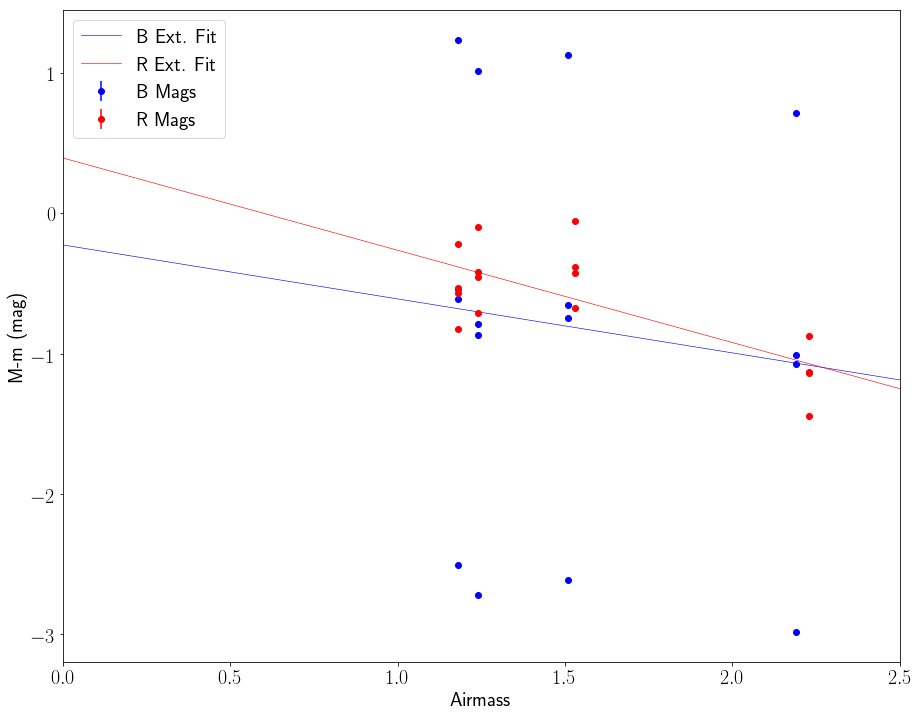

In [26]:
#This does the corrections for the B-band and R-band at the same time.
bband_arr = np.zeros(16,dtype=[('ID','f4'),('EXPTIME','f4'),('AIRMASS','f4'),('MEAN_SKY','f4'),
                              ('FLUX','f4'),('MAG','f4'),('MAG_ERR','f4'),('SUM_CNTS','f4')])
rband_arr = np.zeros(16,dtype=[('ID','f4'),('EXPTIME','f4'),('AIRMASS','f4'),('MEAN_SKY','f4'),
                              ('FLUX','f4'),('MAG','f4'),('MAG_ERR','f4'),('SUM_CNTS','f4')])
bfiles = glob.glob('../sci/b/phot*tab.dat')
bfiles = np.sort(bfiles)
rfiles = glob.glob('../sci/r/phot*tab.dat')
rfiles = np.sort(rfiles)
colnames = bband_arr.dtype.names
num_cols = len(colnames)
for i in range(len(bfiles)):
    lower = i * 4
    upper = lower + 4
    temp_arrb = np.loadtxt(bfiles[i],dtype='f4')
    temp_arrr = np.loadtxt(rfiles[i],dtype='f4')
    for j in range(num_cols):
        bband_arr[colnames[j]][lower:upper] = temp_arrb[:,j]
        rband_arr[colnames[j]][lower:upper] = temp_arrr[:,j]
i99b = pg1633_mags['B_MAG'][0] #PG 1633+099I b-band magnitude
a99b = pg1633_mags['B_MAG'][1]
d99b = pg1633_mags['B_MAG'][2]
b99b = pg1633_mags['B_MAG'][3]

i99r = pg1633_mags['R_MAG'][0] #PG 1633+099I r-band magnitude
a99r = pg1633_mags['R_MAG'][1]
d99r = pg1633_mags['R_MAG'][2]
b99r = pg1633_mags['R_MAG'][3]
mag_diffb = np.zeros(16,dtype=[('OBJ_CHAR','U1'),('AC_MAG','f4'),('INS_MAG','f4'),('CORR_MAG','f4'),
                              ('MAG_DIFF','f4'),('AIRMASS','f4'),('MAG_ERR','f4')])
mag_diffr = np.zeros(16,dtype=[('OBJ_CHAR','U1'),('AC_MAG','f4'),('INS_MAG','f4'),('CORR_MAG','f4'),
                              ('MAG_DIFF','f4'),('AIRMASS','f4'),('MAG_ERR','f4')])
for i in range(16):
    mag_diffb['INS_MAG'][i] = bband_arr['MAG'][i]
    mag_diffr['INS_MAG'][i] = rband_arr['MAG'][i]
    if bband_arr['ID'][i] == 1.:
        mag_diffb['OBJ_CHAR'][i] = 'A'
        mag_diffb['AC_MAG'][i] = a99b
    elif bband_arr['ID'][i] == 2.:
        mag_diffb['OBJ_CHAR'][i] = 'I'
        mag_diffb['AC_MAG'][i] = i99b
    elif bband_arr['ID'][i] == 3.:
        mag_diffb['OBJ_CHAR'][i] = 'D'
        mag_diffb['AC_MAG'][i] = d99b
    elif bband_arr['ID'][i] == 4.:
        mag_diffb['OBJ_CHAR'][i] = 'B'
        mag_diffb['AC_MAG'][i] = b99b
    if rband_arr['ID'][i] == 1.:
        mag_diffr['OBJ_CHAR'][i] = 'A'
        mag_diffr['AC_MAG'][i] = a99r
    elif rband_arr['ID'][i] == 2.:
        mag_diffr['OBJ_CHAR'][i] = 'I'
        mag_diffr['AC_MAG'][i] = i99r
    elif rband_arr['ID'][i] == 3.:
        mag_diffr['OBJ_CHAR'][i] = 'D'
        mag_diffr['AC_MAG'][i] = d99r
    elif rband_arr['ID'][i] == 4.:
        mag_diffr['OBJ_CHAR'][i] = 'B'
        mag_diffr['AC_MAG'][i] = b99r
    mag_diffb['AIRMASS'][i] = bband_arr['AIRMASS'][i]
    mag_diffb['MAG_ERR'][i] = bband_arr['MAG_ERR'][i]
    mag_diffb['MAG_DIFF'][i] = mag_diffb['AC_MAG'][i] - mag_diffb['INS_MAG'][i]
    
    mag_diffr['AIRMASS'][i] = rband_arr['AIRMASS'][i]
    mag_diffr['MAG_ERR'][i] = rband_arr['MAG_ERR'][i]
    mag_diffr['MAG_DIFF'][i] = mag_diffr['AC_MAG'][i] - mag_diffr['INS_MAG'][i]
        
#1: A, 2: I, 3: D, 4: B
#maxmag = np.amax(vband_arr['MAG']+3)
prmb = np.polyfit(mag_diffb['AIRMASS'],mag_diffb['MAG_DIFF'],1)
#prmb = np.polyfit(mag_diffb['AIRMASS'],mag_diffb['INS_MAG'],1)
prmr = np.polyfit(mag_diffr['AIRMASS'],mag_diffr['MAG_DIFF'],1)
#prmr = np.polyfit(mag_diffr['AIRMASS'],mag_diffr['INS_MAG'],1)
kb1 = prmb[0] #EXTINCTION COEFFICIENT FOR B-band
zpb = prmb[1] #Zero Point offset
kr1 = prmr[0] #EXTINCTION COEFFICIENT FOR R-band
zpr = prmr[1] #Zero Point offset
print('Extinction Coefficient (kb): {:05.3f}'.format(kb1))
print('Zero Point Offset (zpB): {:05.3f}'.format(zpb))
print('Extinction Coefficient (kr): {:05.3f}'.format(kr1))
print('Zero Point Offset (zpR): {:05.3f}'.format(zpr))
x_fit = np.linspace(0,2.5,1000)
y_fitb = np.polyval(prmb,x_fit)
y_fitr = np.polyval(prmr,x_fit)
blab_pnts = 'B Mags'
rlab_pnts = 'R Mags'
plt.errorbar(mag_diffb['AIRMASS'],mag_diffb['MAG_DIFF'],yerr=mag_diffb['MAG_ERR'],fmt='o',color='blue',label=blab_pnts)
plt.errorbar(mag_diffr['AIRMASS'],mag_diffr['MAG_DIFF'],yerr=mag_diffr['MAG_ERR'],fmt='o',color='red',label=rlab_pnts)
blab_line = 'B Ext. Fit'
rlab_line = 'R Ext. Fit'
plt.plot(x_fit,y_fitb,linewidth=0.6,label=blab_line,color='blue')
plt.plot(x_fit,y_fitr,linewidth=0.6,label=rlab_line,color='red')
#plt.ylim((0,2))
plt.xlim((0,2.5))
plt.legend()
plt.xlabel('Airmass')
plt.ylabel('M-m (mag)');
mag_diffb['CORR_MAG'] = mag_diffb['INS_MAG'] + (kb1 * mag_diffb['AIRMASS']) + zpb
mag_diffr['CORR_MAG'] = mag_diffr['INS_MAG'] + (kr1 * mag_diffr['AIRMASS']) + zpr

### 12) Color Correction for B,V,R

Below is the script to find the color correction terms in B (using b-v), V (using 0 as it is the standard), and R (using v-r). The color coefficient terms are at the bottom of the code (above the plot). The plot for v-r appears first, then b-v. As above, lower case refers to my magnitudes while upper case refers to accepted (published) magnitudes.

Color Correction Coeffcient (k_[v-r]): -0.012


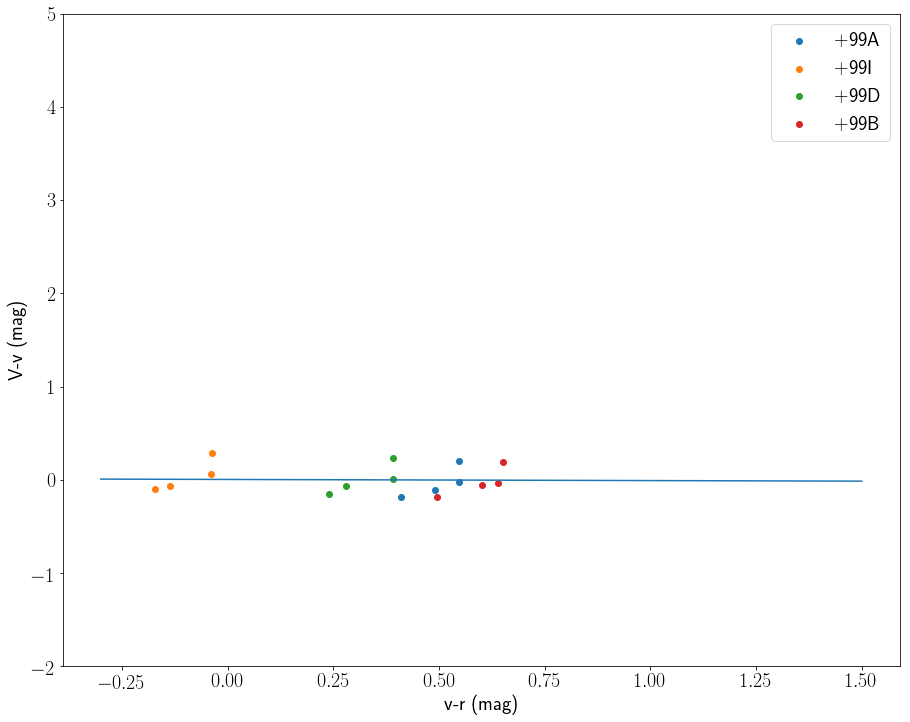

In [25]:
obj_arr = np.zeros(3,dtype=[('BAND','U1'),('ACC_MAG','f4',4),('MY_MAG','f4',(4,4)),
                             ('CDIFF','f4',(4,4)),('MAG_DIFF','f4',(4,4))])
wa = np.where(mag_diff['OBJ_CHAR']=='A')
wi = np.where(mag_diff['OBJ_CHAR']=='I')
wd = np.where(mag_diff['OBJ_CHAR']=='D')
wb = np.where(mag_diff['OBJ_CHAR']=='B')
obj_arr['BAND'][0] = 'B'
obj_arr['BAND'][1] = 'V'
obj_arr['BAND'][2] = 'R'

obj_arr['ACC_MAG'][0] = pg1633_mags['B_MAG'] #A, I, D, B
obj_arr['ACC_MAG'][1] = pg1633_mags['V_MAG']
obj_arr['ACC_MAG'][2] = pg1633_mags['R_MAG']

obj_arr['MY_MAG'][0][0,:] = mag_diffb['CORR_MAG'][wa] #Row 0, a083,a132,a204,a239 OBJ A
obj_arr['MY_MAG'][0][1,:] = mag_diffb['CORR_MAG'][wi] #Row 1, OBJ I
obj_arr['MY_MAG'][0][2,:] = mag_diffb['CORR_MAG'][wd] #Row 2, OBJ D
obj_arr['MY_MAG'][0][3,:] = mag_diffb['CORR_MAG'][wb] #Row 3, OBJ B

obj_arr['MY_MAG'][1][0,:] = mag_diff['CORR_MAG'][wa] #Row 0, a085,a134,a206,a241 OBJ A
obj_arr['MY_MAG'][1][1,:] = mag_diff['CORR_MAG'][wi] #Row 1, OBJ I
obj_arr['MY_MAG'][1][2,:] = mag_diff['CORR_MAG'][wd] #Row 2, OBJ D
obj_arr['MY_MAG'][1][3,:] = mag_diff['CORR_MAG'][wb] #Row 3, OBJ B

obj_arr['MY_MAG'][2][0,:] = mag_diffr['CORR_MAG'][wa] #Row 0, a087,a136,a208,a243 OBJ A
obj_arr['MY_MAG'][2][1,:] = mag_diffr['CORR_MAG'][wi] #Row 1, OBJ I
obj_arr['MY_MAG'][2][2,:] = mag_diffr['CORR_MAG'][wd] #Row 2, OBJ D
obj_arr['MY_MAG'][2][3,:] = mag_diffr['CORR_MAG'][wb] #Row 3, OBJ B

obj_arr['CDIFF'][0] = obj_arr['MY_MAG'][0] - obj_arr['MY_MAG'][1] #B-V
obj_arr['CDIFF'][1] = 0
obj_arr['CDIFF'][2] = obj_arr['MY_MAG'][1] - obj_arr['MY_MAG'][2] #V-R
obj_arr['MAG_DIFF'][0][0,:] = -obj_arr['MY_MAG'][0][0,:] + obj_arr['ACC_MAG'][0][0]
obj_arr['MAG_DIFF'][0][1,:] = -obj_arr['MY_MAG'][0][1,:] + obj_arr['ACC_MAG'][0][1]
obj_arr['MAG_DIFF'][0][2,:] = -obj_arr['MY_MAG'][0][2,:] + obj_arr['ACC_MAG'][0][2]
obj_arr['MAG_DIFF'][0][3,:] = -obj_arr['MY_MAG'][0][3,:] + obj_arr['ACC_MAG'][0][3]

obj_arr['MAG_DIFF'][1][0,:] = -obj_arr['MY_MAG'][1][0,:] + obj_arr['ACC_MAG'][1][0]
obj_arr['MAG_DIFF'][1][1,:] = -obj_arr['MY_MAG'][1][1,:] + obj_arr['ACC_MAG'][1][1]
obj_arr['MAG_DIFF'][1][2,:] = -obj_arr['MY_MAG'][1][2,:] + obj_arr['ACC_MAG'][1][2]
obj_arr['MAG_DIFF'][1][3,:] = -obj_arr['MY_MAG'][1][3,:] + obj_arr['ACC_MAG'][1][3]

obj_arr['MAG_DIFF'][2][0,:] = -obj_arr['MY_MAG'][2][0,:] + obj_arr['ACC_MAG'][2][0]
obj_arr['MAG_DIFF'][2][1,:] = -obj_arr['MY_MAG'][2][1,:] + obj_arr['ACC_MAG'][2][1]
obj_arr['MAG_DIFF'][2][2,:] = -obj_arr['MY_MAG'][2][2,:] + obj_arr['ACC_MAG'][2][2]
obj_arr['MAG_DIFF'][2][3,:] = -obj_arr['MY_MAG'][2][3,:] + obj_arr['ACC_MAG'][2][3]

parR = np.polyfit(np.ravel(obj_arr['CDIFF'][2]),np.ravel(obj_arr['MAG_DIFF'][2]),1)
parB = np.polyfit(np.ravel(obj_arr['CDIFF'][0]),np.ravel(obj_arr['MAG_DIFF'][0]),1)
print(r'Color Correction Coeffcient (k_[v-r]): {:05.3f}'.format(parR[0]))
x_fitR = np.linspace(-0.3,1.5,1000)
y_fitR = np.polyval(parR,x_fitR)
y_fitB = np.polyval(parB,x_fitR)

#print(obj_arr[0])
plt.scatter(obj_arr['CDIFF'][2][0],obj_arr['MAG_DIFF'][2][0],label='+99A')
plt.scatter(obj_arr['CDIFF'][2][1],obj_arr['MAG_DIFF'][2][1],label='+99I')
plt.scatter(obj_arr['CDIFF'][2][2],obj_arr['MAG_DIFF'][2][2],label='+99D')
plt.scatter(obj_arr['CDIFF'][2][3],obj_arr['MAG_DIFF'][2][3],label='+99B')
plt.plot(x_fitR,y_fitR)
plt.ylim((-2,5))
plt.legend()
plt.xlabel('v-r (mag)')
plt.ylabel('V-v (mag)');

Below is the code for the b-v corrections.

Color Correction Coeffcient (k_[b-v]): 0.111


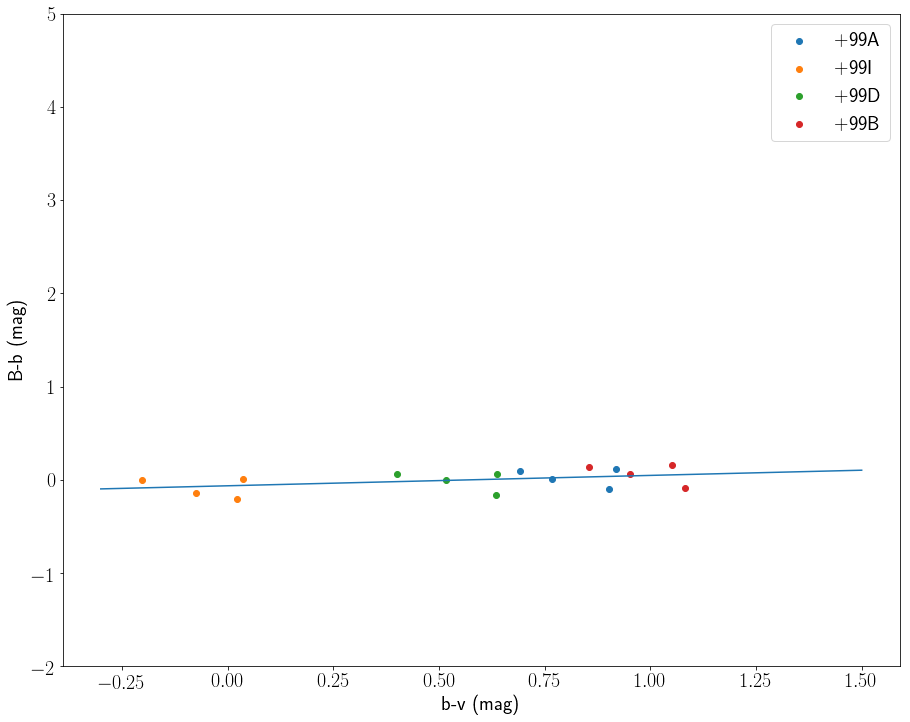

In [27]:
print(r'Color Correction Coeffcient (k_[b-v]): {:05.3f}'.format(parB[0]))
plt.scatter(obj_arr['CDIFF'][0][0],obj_arr['MAG_DIFF'][0][0],label='+99A')
plt.scatter(obj_arr['CDIFF'][0][1],obj_arr['MAG_DIFF'][0][1],label='+99I')
plt.scatter(obj_arr['CDIFF'][0][2],obj_arr['MAG_DIFF'][0][2],label='+99D')
plt.scatter(obj_arr['CDIFF'][0][3],obj_arr['MAG_DIFF'][0][3],label='+99B')
plt.plot(x_fitR,y_fitB)
plt.legend()
plt.xlabel('b-v (mag)')
plt.ylabel('B-b (mag)')
plt.ylim((-2,5));

In [28]:
title_str = '  BAND   |  Ext. Coeff (k1)  |  Zero Point  |  Color Coeff.'
break_str = '------------------------------------------------------------'
b_str = '    B    |       {0:05.3f}      |    {1:05.3f}    |    {2:05.3f} '.format(kb1,zpb,parB[0])
v_str = '    V    |       {0:05.3f}      |    {1:6.3f}    |    0.0 '.format(kv1,zpv)
r_str = '    R    |       {0:05.3f}      |    {1:6.3f}    |   {2:05.3f} '.format(kr1,zpr,parR[0])
print(title_str)
print(break_str)
print(b_str)
print(v_str)
print(r_str)

  BAND   |  Ext. Coeff (k1)  |  Zero Point  |  Color Coeff.
------------------------------------------------------------
    B    |       -0.385      |    -0.225    |    0.111 
    V    |       -0.448      |     0.045    |    0.0 
    R    |       -0.659      |     0.396    |   -0.012 


Finally, these are the values I will use to correct the science images for other targets.